# Exploring the Statistics of Milk Production: Weather

## Background

This notebook is intended to test hypotheses relating to weather and milk production, based on diary .  For additional context please see the [summary notebook](statistics_of_milk_production.ipynb).

---

## Selected Terms

The following terms and definitions should be useful for understanding the contents of this analysis.  

- **Milk Weight:** The amount of milk produced by an animal.  Measured in pounds of milk. For reference, a gallon of milk weighs approximately 8.6 pounds.
- **Extreme Temperature Day:** A day were the maximum temperature excedes 90(F) or the minimum temperature is below 10(F). 

---

## Hypotheses

The analysis seeks to test the following hypotheses:

### Test Hypothesis H-Tmax: Maximum Temperature and Milk Weight

- **Ho-Tmax:** The weekly average of maximum temperatures is not correlated with weekly per-capita milk production.
- **Ha-Tmax:** The weekly average of maximum temperatures is correlated with weekly per-capita milk production.

### Test Hypothesis H-Tmin: Minimum Temperature and Milk Weight

- **Ho-Tmin:** The weekly average of minimum temperatures is not correlated with weekly per-capita milk production.
- **Ha-Tmin:** The weekly average of minimum temperatures not correlated with weekly per-capita milk production.

### Test Hypothesis H-Tex: Extreme Temperature and Milk Weight

- **Ho-Tex:** The number of extreme temperature days per week is not correlated with per-capita weekly milk production.
- **Ha-Tex:** The number of extreme temperature days per week is not correlated with per-capita weekly milk production.

---

### Conclusions

No statistically signiciant linear correlation was found between weekly milk production and maximum temperature, weekly milk production and minimum temperature, or weekly production and days of extreme temperature.  As a result we cannot reject the null hypothesis above.

In [44]:
import sys
sys.path.insert(0, '../scripts')
sys.path.insert(0, '../data/database')
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Data Retrieval
engine =  create_engine('sqlite:///../data/database/happycows.db')
with engine.connect() as con:
    milk = pd.read_sql_table('milk_volume', con)
    weather = pd.read_sql_table('weather', con)

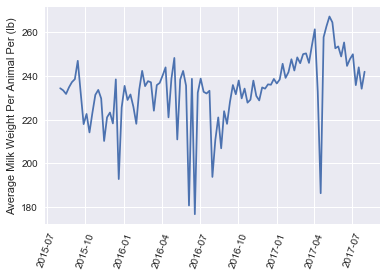

In [46]:
def select_features(data):
    return data[['date', 'animal_id', 'milk_weight']]
    
def transform_date(data):
    data['date'] = pd.to_datetime(data['date'].dt.date)
    return data

def get_daily_animal_milk_weight(data):
    return data.groupby(['date', 'animal_id']).sum().reset_index()

def get_daily_herd_average_milk_weight(data):
    return data.reset_index().groupby('date').mean()['milk_weight'].reset_index()

def get_weekly_totals(data):
    return data.set_index('date').resample('W').sum().reset_index()
    

milk = select_features(milk)
milk = transform_date(milk)
milk = get_daily_animal_milk_weight(milk)
milk = get_daily_herd_average_milk_weight(milk)
milk = get_weekly_totals(milk)
milk = milk.set_index('date')['2015-08-01':'2017-07-30']

sns.set()
_ = plt.plot(milk)
_ = plt.ylabel('Average Milk Weight Per Animal Per (lb)')
_ = plt.xticks(rotation=70)
plt.show()


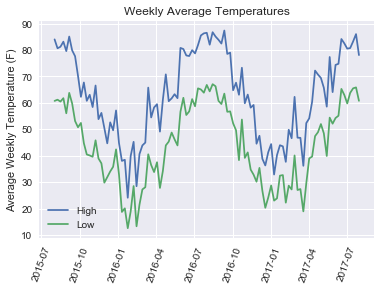

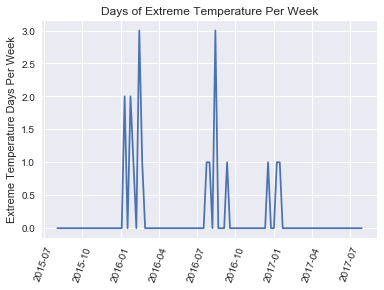

In [47]:
def get_weekly_summary(data):
    ws = pd.DataFrame()
    ws['average_max_temp'] = data.resample('W').mean()['tmax']
    ws['average_min_temp'] = data.resample('W').mean()['tmin']
    ws['extreme_days'] = data.resample('W').sum()['is_hot'] + data.resample('W').sum()['is_cold'] 
    return ws

weather = weather.set_index('date')['2015-08-01':'2017-07-30']
weekly_summary = get_weekly_summary(weather)

sns.set()
_ = plt.plot(weekly_summary[['average_max_temp', 'average_min_temp']])
_ = plt.ylabel('Average Weekly Temperature (F)')
_ = plt.xticks(rotation=70)
_ = plt.title("Weekly Average Temperatures")
plt.legend(['High', 'Low'])
plt.show()

_ = plt.plot(weekly_summary[['extreme_days']])
_ = plt.ylabel('Extreme Temperature Days Per Week')
_ = plt.title("Days of Extreme Temperature Per Week")
_ = plt.xticks(rotation=70)
plt.show()

In [48]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0,1]

def calculate_correlation_and_p_value(x, y, permutations=10000, alpha=0.05):
    obs_r = pearson_r(x, y)
    perm_replicates = np.empty(permutations)
    for i in range(permutations):
        y_permutated = np.random.permutation(y)
        perm_replicates[i] = pearson_r(x, y_permutated)
    
    p = np.sum(perm_replicates >= obs_r) / len(perm_replicates)
    
    print(f'     r = {obs_r}')
    print(f' p-val = {p}')
    print(f' alpha = {alpha}\n')
    if p < alpha:
        print("The correlation is statistically significant at this p-value and alpha level.\n")
    else:
        print("The correlation is not statistically significant at this p-value and alpha level.\n")
    
    return obs_r, p

In [50]:
# Hypothesis Test Ho-Tmax
r, p = calculate_correlation_and_p_value(milk['milk_weight'], weekly_summary['average_max_temp'])

Testing the relationship between average maximum temperature and average weekly milk production
     r = -0.15689969983791774
 p-val = 0.9483
 alpha = 0.05

The correlation is not statistically significant at this p-value and alpha level.



In [51]:
# Hypothesis Test Ho-Tmin
r, p = calculate_correlation_and_p_value(milk['milk_weight'], weekly_summary['average_min_temp'])

     r = -0.1545959699981437
 p-val = 0.9435
 alpha = 0.05

The correlation is not statistically significant at this p-value and alpha level.



In [52]:
# Hypothesis Test Ho-Tmin
r, p = calculate_correlation_and_p_value(milk['milk_weight'], weekly_summary['extreme_days'])

     r = -0.08601174999363977
 p-val = 0.8255
 alpha = 0.05

The correlation is not statistically significant at this p-value and alpha level.

